# SSD300 Inference for Deepfake Detection

This is a brief tutorial that shows how to use a trained SSD300 to visualize predictions.

In [1]:
# Loading in the necessary Python modules
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set the image size.
img_height = 300
img_width = 300

## 1. Load a trained SSD300 model

In [3]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = './model_output/ssd300_epoch-08_loss-2.5144_val_loss-4.1434.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})















Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.




## 2. Make predictions on an image without ground truth annotations

In [4]:
# Load an image, without ground truth annotations, for which I'd like the model to make predictions.
orig_images = [] # Store the image(s) here.
input_images = [] # Store resized versions of the image(s) here.

# TODO: Set the path to the image to be loaded.
img_path = './images_dir/py-keras-job-dir/all_videos/practice_video_fake1_00209.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

In [5]:
# Make predictions on the image
y_pred = model.predict(input_images)

Now let's decode the raw predictions in y_pred.

Had we created the model in 'inference' or 'inference_fast' mode, then the model's final layer would be a `DecodeDetections` layer and y_pred would already contain the decoded predictions, but since we created the model in 'training' mode, the model outputs raw predictions that still need to be decoded and filtered. This is what the `decode_detections()` function is for. It does exactly what the `DecodeDetections` layer would do, but using Numpy instead of TensorFlow (i.e. on the CPU instead of the GPU).

`decode_detections()` with default argument values follows the procedure of the original SSD implementation: First, a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes, then greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45, and out of what is left after that, the top 200 highest confidence boxes are returned. Those settings are for precision-recall scoring purposes though. In order to get some usable final predictions, we'll set the confidence threshold much higher, e.g. to 0.5, since we're only interested in the very confident predictions. `top_k` is per batch item. If the predictions ends up being of low quality, I can always increase the `confidence_thresh` value however I see fit.

In [6]:
# Decode the raw predictions in `y_pred`.
y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=True,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[0])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  2.     0.5  180.71  75.73 204.76 140.66]]


We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

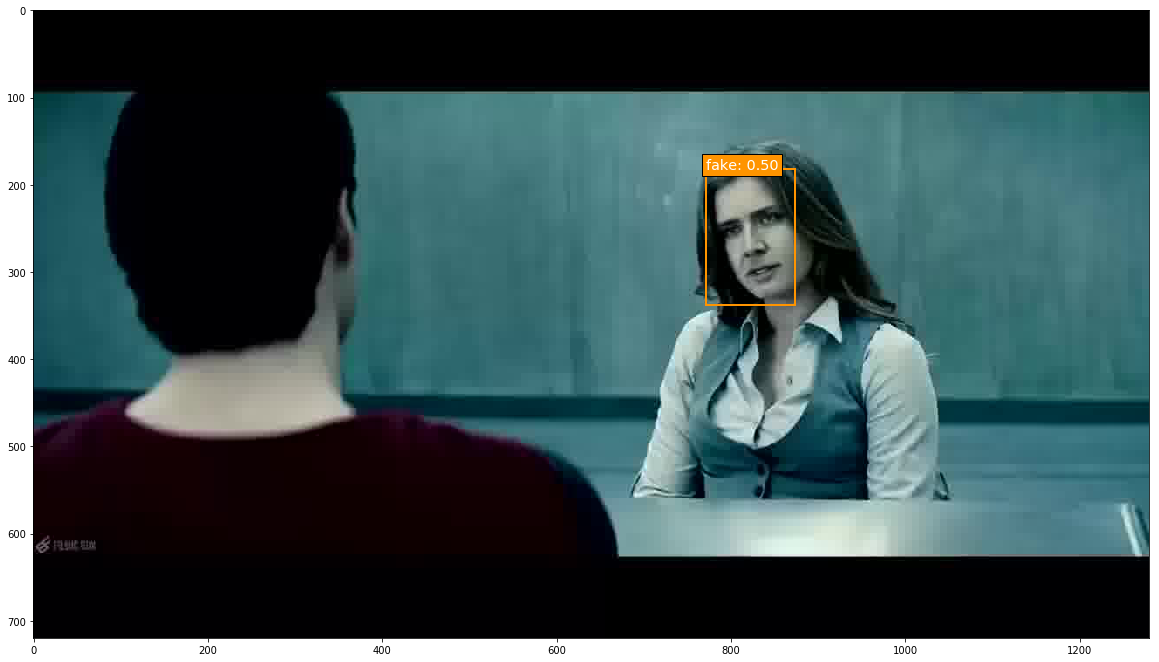

In [7]:
# Display the image and draw the predicted box(es) onto it.

# Set the colors for the bounding boxes
n_classes = 2
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background',
           'real', 'fake']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

# TODO: Set the name of the output image for the image being predicted.
for box in y_pred_decoded[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
    plt.savefig('./predictions/practice_video_fake1_00209_predict.png')

## 3. Make predictions on an image with ground truth annotations

Let's use a `DataGenerator` to make predictions on an image and visualize the predicted boxes alongside the ground truth boxes for comparison.

In [8]:
# Create a `DataGenerator` instance and parse the image labels.

dataset = DataGenerator()

# TODO: Set the paths to the images and labels here.

# The directory that contains the images
images_dir = './images_dir/py-keras-job-dir/all_videos/'

# CSV file of the ground truth image annotation labels
image_labels_filename = './predictions/practice_video_fake1_00209.csv'

dataset.parse_csv(images_dir=images_dir,
                  labels_filename=image_labels_filename,
                  input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                  include_classes='all')

convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

generator = dataset.generate(batch_size=1,
                             shuffle=True,
                             transformations=[convert_to_3_channels,
                                              resize],
                             returns={'processed_images',
                                      'filenames',
                                      'inverse_transform',
                                      'original_images',
                                      'original_labels'},
                             keep_images_without_gt=False)

In [9]:
# Generate a batch and make predictions on the image.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: ./images_dir/py-keras-job-dir/all_videos/practice_video_fake1_00209.jpg

Ground truth boxes:

[[  2 777 149 899 334]]


In [10]:
# Make predictions.

y_pred = model.predict(batch_images)

Now let's decode the raw predictions in y_pred.

Had we created the model in 'inference' or 'inference_fast' mode, then the model's final layer would be a `DecodeDetections` layer and y_pred would already contain the decoded predictions, but since we created the model in 'training' mode, the model outputs raw predictions that still need to be decoded and filtered. This is what the `decode_detections()` function is for. It does exactly what the `DecodeDetections` layer would do, but using Numpy instead of TensorFlow (i.e. on the CPU instead of the GPU).

`decode_detections()` with default argument values follows the procedure of the original SSD implementation: First, a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes, then greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45, and out of what is left after that, the top 200 highest confidence boxes are returned. Those settings are for precision-recall scoring purposes though. In order to get some usable final predictions, we'll set the confidence threshold much higher, e.g. to 0.5, since we're only interested in the very confident predictions. `top_k` is per batch item. If I end up with too many predicted boxes I can always lower this value, or increase the `confidence_thresh`.

In [11]:
# Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=True,
                                   img_height=img_height,
                                   img_width=img_width)

We made the predictions on the resized images, but we'd like to visualize the outcome on the original input images, so we'll convert the coordinates accordingly. Don't worry about that opaque `apply_inverse_transforms()` function below, in this simple case it just applies (* `original_image_size` / `resized_image_size`) to the box coordinates.

In [12]:
# Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  2.     0.53 771.   181.   873.   337.  ]]


Finally, let's draw the predicted boxes onto the image. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

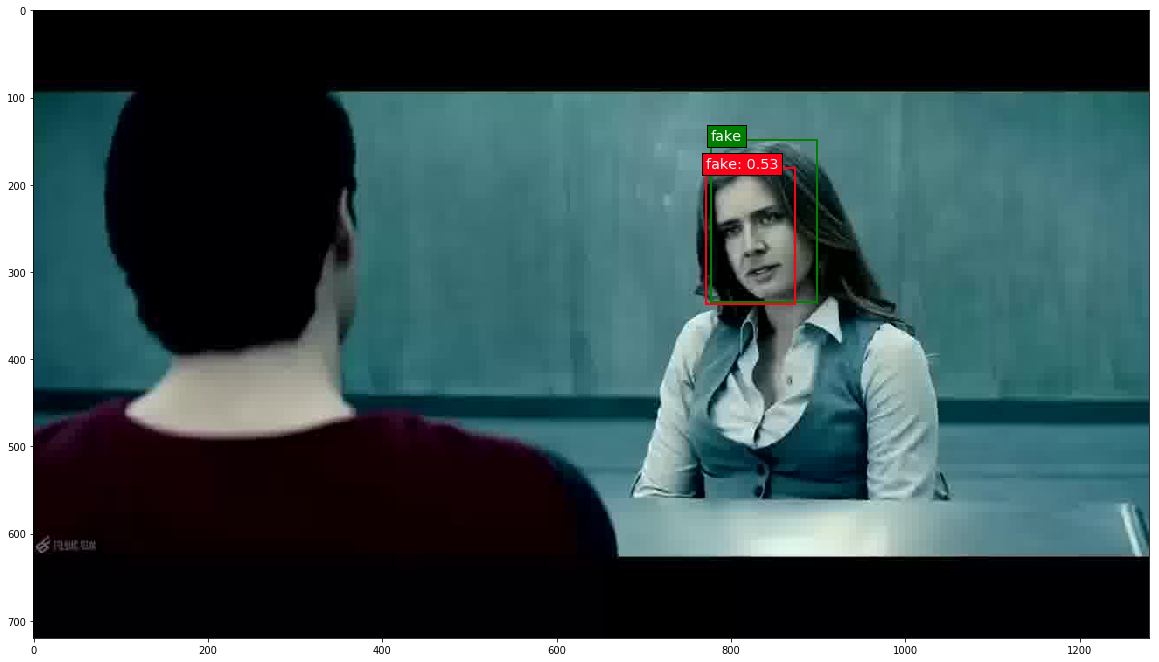

In [13]:
# Draw the predicted box(es) onto the image.

# Set the colors for the bounding boxes
n_classes = 2
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background',
           'real', 'fake']

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# TODO: Set the name of the output image for the image being predicted.
for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
    plt.savefig('./predictions/practice_video_fake1_00209_predict.png')